In [1]:
import os
import sys
import pickle
import numpy as np
from math import exp
from scipy import stats
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
from vizsequence.viz_sequence import plot_weights_given_ax
from scipy.special import softmax
import keras
import keras.losses
from keras.models import Model, Sequential, load_model
from keras import backend as K
import numpy.random as rng
import seaborn as sns
from collections import OrderedDict
from basepair.losses import twochannel_multinomial_nll
import modisco
import modisco.tfmodisco_workflow.workflow
from modisco.tfmodisco_workflow import workflow
import h5py
import modisco.util
from collections import Counter
from modisco.visualization import viz_sequence
import modisco.affinitymat.core
import modisco.cluster.phenograph.core
import modisco.cluster.phenograph.cluster
import modisco.cluster.core
import modisco.aggregator
%matplotlib inline

Using TensorFlow backend.
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/users/amr1/mi

2020-11-05 07:24:51,900 [WARNING] From /users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

TF-MoDISco is using the TensorFlow backend.


In [2]:
all_post_profile_hypimps = np.load("/users/amr1/pho4/data/imp-scores/cbf1_chipexo/post_profile_hypimps.npy")
all_post_profile_actualimps = np.load("/users/amr1/pho4/data/imp-scores/cbf1_chipexo/post_profile_actualimps.npy")  
all_seqs = np.load("/users/amr1/pho4/data/imp-scores/cbf1_chipexo/seqs.npy")

In [3]:
track_set = modisco.tfmodisco_workflow.workflow.prep_track_set(
                task_names=["cbf1"],
                contrib_scores={"cbf1": all_post_profile_actualimps[0]},
                hypothetical_contribs={"cbf1": all_post_profile_hypimps[0]},
                one_hot=all_seqs)

grp = h5py.File("/users/amr1/pho4/data/modisco/cbf1_chipexo/cbf1_profile/results.hdf5","r")
loaded_tfmodisco_results =\
    workflow.TfModiscoResults.from_hdf5(grp, track_set=track_set)
grp.close()

Untrimmed - sequence (scaled by information content)


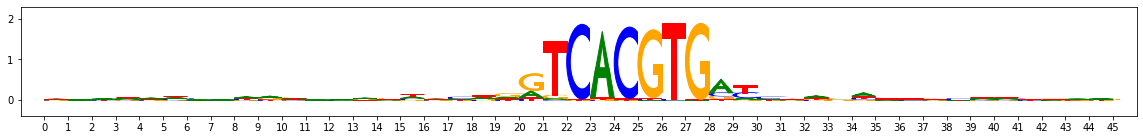

Untrimmed - task 0 hypothetical scores


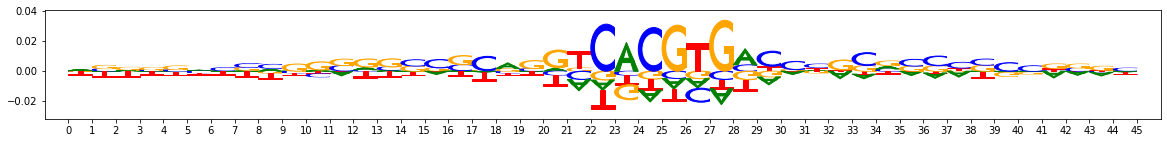

IC-trimmed - sequence (scaled by information content)


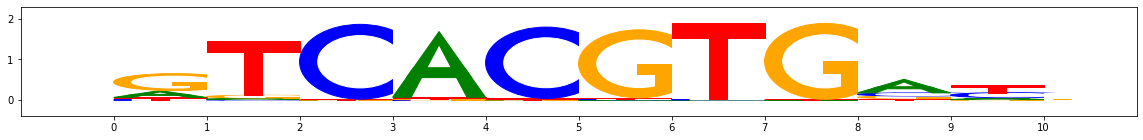

In [4]:
background = np.array([0.27, 0.23, 0.23, 0.27])
untrimmed_pattern = (
    loaded_tfmodisco_results
    .metacluster_idx_to_submetacluster_results["metacluster_0"]
    .seqlets_to_patterns_result.patterns[0])
print("Untrimmed - sequence (scaled by information content)")
viz_sequence.plot_weights(viz_sequence.ic_scale(untrimmed_pattern["sequence"].fwd, background=background))
print("Untrimmed - task 0 hypothetical scores")
viz_sequence.plot_weights(untrimmed_pattern["cbf1_hypothetical_contribs"].fwd)
trimmed = untrimmed_pattern.trim_by_ic(ppm_track_name="sequence", background=background, threshold=0.3)
print("IC-trimmed - sequence (scaled by information content)")
viz_sequence.plot_weights(viz_sequence.ic_scale(trimmed["sequence"].fwd, background=background))

In [5]:
print(trimmed["cbf1_hypothetical_contribs"].fwd)

[[ 0.00230743 -0.00251955  0.01172448 -0.00756999]
 [-0.00746912 -0.00549487  0.00212732  0.01138879]
 [-0.00685472  0.03122185 -0.00576462 -0.01204871]
 [ 0.01917931 -0.00260549 -0.00996858 -0.00631053]
 [-0.00795818  0.02894712 -0.00522607 -0.00718583]
 [-0.00714244 -0.00485943  0.03052259 -0.00784492]
 [-0.0063491  -0.00930247 -0.005005    0.01864136]
 [-0.01055759 -0.00546898  0.03382013 -0.00613555]
 [ 0.01066648  0.00423452 -0.00558967 -0.00773408]
 [-0.00525679  0.00998581 -0.00379025  0.00328875]]


In [8]:
imp_scores = all_post_profile_actualimps[0]
onehot_seq = np.array(all_seqs)
fwd_masked_cosine_sim = modisco.util.compute_masked_cosine_sim(
                                     imp_scores=imp_scores,
                                     onehot_seq=onehot_seq,
                                     weightmat=trimmed["cbf1_hypothetical_contribs"].fwd)
rev_masked_cosine_sim = modisco.util.compute_masked_cosine_sim(
                                     imp_scores=imp_scores,
                                     onehot_seq=onehot_seq,
                                     weightmat=trimmed["cbf1_hypothetical_contribs"].rev)

#We take the max of the masked_cosine_sim on the fwd and reverse strands
is_fwd_masked_cosine_sim = fwd_masked_cosine_sim > rev_masked_cosine_sim
masked_cosine_sim = (fwd_masked_cosine_sim*is_fwd_masked_cosine_sim
                     + rev_masked_cosine_sim*(is_fwd_masked_cosine_sim==False))

#Also look at the total sum of scores in each window
sum_scores = modisco.util.compute_sum_scores(imp_scores=imp_scores,
                                             window_size=len(trimmed["cbf1_hypothetical_contribs"].fwd))

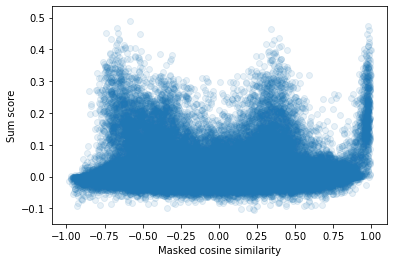

In [9]:
plt.scatter(masked_cosine_sim.ravel(), sum_scores.ravel(), alpha=0.1)
plt.xlabel("Masked cosine similarity")
plt.ylabel("Sum score")
plt.show()

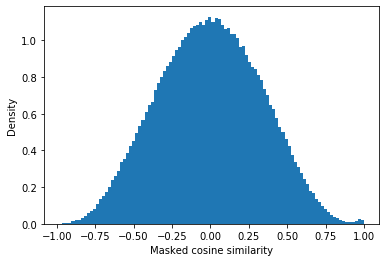

In [10]:
plt.hist(masked_cosine_sim.ravel(), bins=100, density=True)
plt.xlabel("Masked cosine similarity")
plt.ylabel("Density")
plt.show()

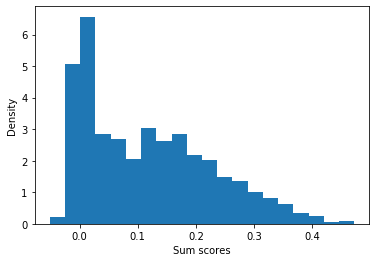

In [15]:
masked_cosine_sim_thresh = 0.85
plt.hist(sum_scores.ravel()[masked_cosine_sim.ravel() > masked_cosine_sim_thresh],
         bins=20, density=True)
plt.xlabel("Sum scores")
plt.ylabel("Density")
plt.show()

In [23]:
sum_score_thresh = 0.16
threshold_passers = ((masked_cosine_sim > masked_cosine_sim_thresh)*
                     (sum_scores > sum_score_thresh))

In [24]:
hit_locations = list(zip(*np.nonzero(threshold_passers)))
len(hit_locations)

378

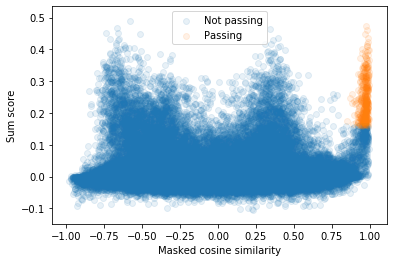

In [25]:
handles = []
handles.append(
    plt.scatter(masked_cosine_sim[threshold_passers==False].ravel(),
            sum_scores[threshold_passers==False].ravel(), alpha=0.1))
handles.append(
    plt.scatter(masked_cosine_sim[threshold_passers].ravel(),
            sum_scores[threshold_passers].ravel(), alpha=0.1))
plt.xlabel("Masked cosine similarity")
plt.ylabel("Sum score")
plt.legend(handles=handles, labels=["Not passing", "Passing"])
plt.show()

cosine similarity: 0.9921760464142525 sum scores: 0.2976323721581139


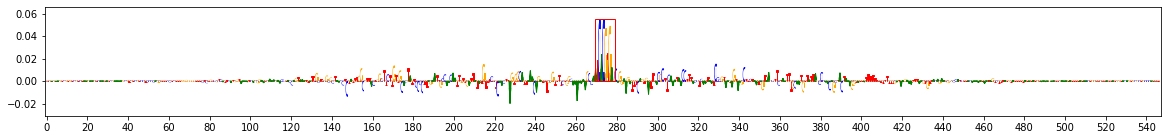

cosine similarity: 0.9678859611719478 sum scores: 0.3001311998676101


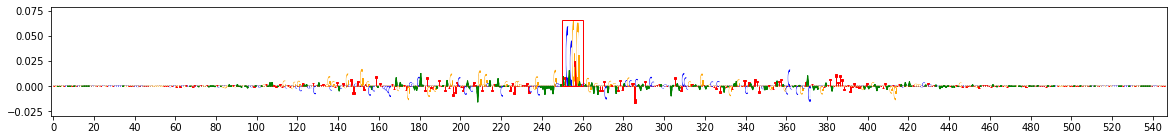

cosine similarity: 0.9711986908814947 sum scores: 0.32797025125473733


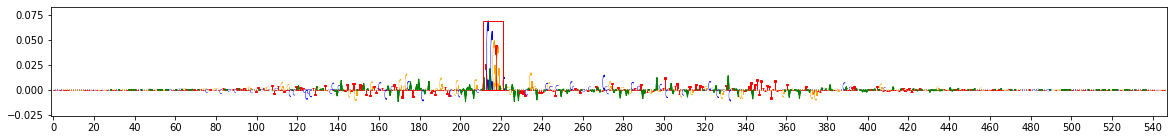

cosine similarity: 0.9713832062326888 sum scores: 0.3530048224551137


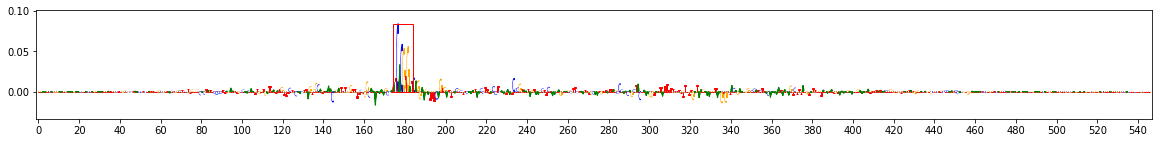

cosine similarity: 0.9841989211193214 sum scores: 0.23310765223868657


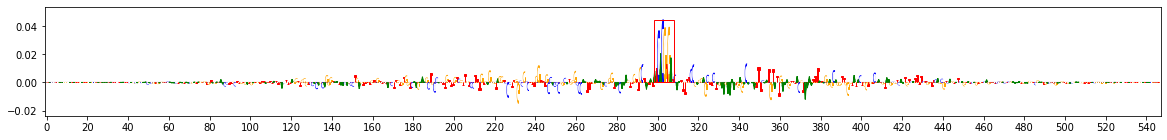

In [27]:
hit_locations = list(zip(*np.nonzero(threshold_passers)))
num_to_viz = 5
for (seq_idx, hit_pos) in hit_locations[:num_to_viz]:
    print("cosine similarity:", masked_cosine_sim[seq_idx,hit_pos],
          "sum scores:", sum_scores[seq_idx, hit_pos])
    fig = plt.figure(figsize=(20,2))
    ax = fig.add_subplot(111)     
    viz_sequence.plot_weights_given_ax(ax=ax,
        array=imp_scores[seq_idx],
        height_padding_factor=0.2,
        length_padding=1.0,
        highlight={'red': [(hit_pos, hit_pos+len(trimmed))]},
        subticks_frequency=20)
    plt.show()

In [28]:
centered_imps = []
for (seq_idx, hit_pos) in hit_locations:
    centered_imps.append(imp_scores[seq_idx][hit_pos-100:hit_pos+100])
centered_imps = np.array(centered_imps)

counts imp


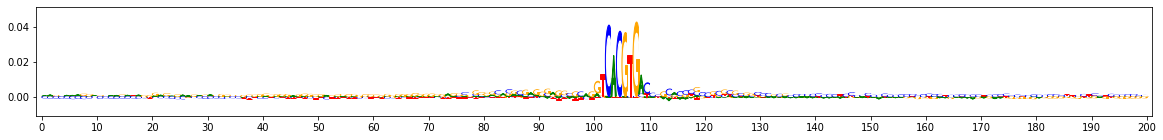

In [29]:
print("counts imp")
viz_sequence.plot_weights(np.mean(centered_imps, axis=0), subticks_frequency=10)

In [30]:
centered_imps.shape

(378, 200, 4)

In [31]:
magnitude_imps = np.sum(centered_imps, axis=-1)

/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':


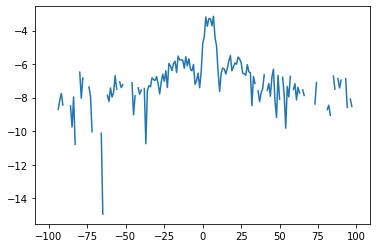

In [32]:
plt.plot(np.arange(-100,100,1), np.log(np.mean(magnitude_imps, axis=0)))

In [ ]:
signal = np.log(np.mean(magnitude_imps, axis=0))
plt.plot(signal[121:181])

In [ ]:
import scipy.signal

L = signal[121:181]
L = np.round(L, 1)
L -= np.mean(L)

In [ ]:
fft = np.fft.rfft(L, norm="ortho")

def abs2(x):
    return x.real**2 + x.imag**2

selfconvol=np.fft.irfft(abs2(fft), norm="ortho")
selfconvol=selfconvol/selfconvol[0]

plt.figure()
plt.plot(selfconvol)
plt.show()

In [ ]:
Ltrunk = L[:44]
plt.plot(Ltrunk)

In [ ]:
fft = np.fft.rfft(Ltrunk, norm="ortho")
selfconvol=np.fft.irfft(abs2(fft), norm="ortho")
selfconvol=selfconvol/selfconvol[0]

plt.figure()
plt.plot(selfconvol)
plt.show()

In [ ]:
5+np.argmax(selfconvol[5:10]), 12+np.argmax(selfconvol[12:20]), 22+np.argmax(selfconvol[22:30]), 30+np.argmax(selfconvol[30:40])

/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':


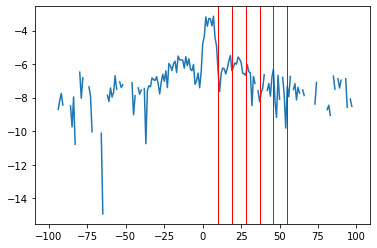

In [35]:
plt.plot(np.arange(-100,100,1), np.log(np.mean(magnitude_imps, axis=0)))
for vline in np.arange(10, 60, 9):
    plt.axvline(x=vline, color='red', linewidth=1.0)

/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':


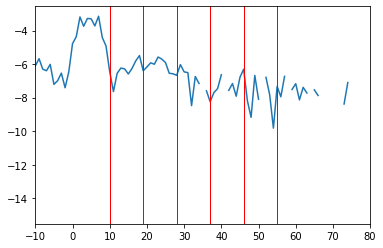

In [36]:
plt.plot(np.arange(-100,100,1), np.log(np.mean(magnitude_imps, axis=0)))
plt.xlim((-10,80))
for vline in np.arange(10, 60, 9):
    plt.axvline(x=vline, color='red', linewidth=1.0)